# HMM with Poisson observations for detecting changepoints in the rate of a signal

Based on https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection


In [1]:
import logging

logging.getLogger("absl").setLevel(logging.CRITICAL)

In [2]:
from jax.config import config

config.update("jax_debug_nans", True)

In [3]:
try:
    import ssm_jax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    import ssm_jax

In [4]:
try:
    import distrax
except ModuleNotFoundError:
    %pip install -qq distrax
    import distrax

In [5]:
import jax.numpy as jnp
from jax import random, jit, lax, vmap, value_and_grad

import tensorflow_probability.substrates.jax as tfp

import optax

import numpy as np
import scipy.stats

from matplotlib import pylab as plt

from ssm_jax.hmm.learning import hmm_fit_sgd
from ssm_jax.hmm.models import PoissonHMM

## Data

The synthetic data corresponds to a single time series of counts, where the rate of the underlying generative process changes at certain points in time.

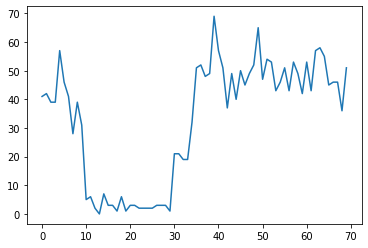

In [6]:
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]
random_state = 0

observed_counts = jnp.concatenate(
    [
        scipy.stats.poisson(rate).rvs(num_steps, random_state=random_state)
        for (rate, num_steps) in zip(true_rates, true_durations)
    ]
).astype(jnp.float32)

# PoissonHMM requires are least 1D emissions
observed_counts = observed_counts[:, None]

plt.plot(observed_counts)

## Model with fixed $K$

To model the changing Poisson rate, we use an HMM. We initially assume the number of states is known to be $K=4$. Later we will try comparing HMMs with different $K$.

We fix the initial state distribution to be uniform, and fix the transition matrix to be the following, where we set $p=0.05$:

$$ \begin{align*} z_1 &\sim \text{Categorical}\left(\left\{\frac{1}{4}, \frac{1}{4}, \frac{1}{4}, \frac{1}{4}\right\}\right)\\ z_t | z_{t-1} &\sim \text{Categorical}\left(\left\{\begin{array}{cc}p & \text{if } z_t = z_{t-1} \\ \frac{1-p}{4-1} & \text{otherwise}\end{array}\right\}\right) \end{align*}$$

In [7]:
def build_latent_state(num_states, max_num_states, daily_change_prob):
    # Give probability 0 to states outside of the current model.
    def prob(s):
        return jnp.where(s < num_states + 1, 1 / num_states, 0.0)

    states = jnp.arange(1, max_num_states + 1)
    initial_state_probs = vmap(prob)(states)

    # Build a transition matrix that transitions only within the current
    # `num_states` states.
    def transition_prob(i, s):
        return jnp.where(
            (s <= num_states) & (i <= num_states) & (1 < num_states),
            jnp.where(s == i, 1 - daily_change_prob, daily_change_prob / (num_states - 1)),
            jnp.where(s == i, 1, 0),
        )

    transition_probs = vmap(transition_prob, in_axes=(None, 0))(states, states)

    return initial_state_probs, transition_probs

In [8]:
num_states = 4
daily_change_prob = 0.05

initial_state_probs, transition_probs = build_latent_state(num_states, num_states, daily_change_prob)
print("Initial state probs:\n{}".format(initial_state_probs))
print("Transition matrix:\n{}".format(transition_probs))

Initial state probs:
[0.25 0.25 0.25 0.25]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


Now we create an HMM where the observation distribution is a Poisson with learnable parameters. We specify the parameters in log space and initialize them to random values around the log of the overall mean count (to set the scal

## Model fitting using Gradient Descent

We compute a MAP estimate of the Poisson rates $\lambda$ using batch gradient descent, using the Adam optimizer applied to the log likelihood (from the HMM) plus the log prior for $p(\lambda)$.

In [9]:
rng_key = random.PRNGKey(0)
rng_key, rng_normal, rng_poisson = random.split(rng_key, 3)

In [10]:
# Define variable to represent the unknown log rates.
trainable_rates = jnp.exp(jnp.log(jnp.mean(observed_counts)) + random.normal(rng_normal, (num_states, 1)))
hmm = PoissonHMM(initial_state_probs, transition_probs, trainable_rates)

hmm.initial_probs.freeze()
hmm.transition_matrix.freeze()

rate_prior = distrax.LogStddevNormal(5, 5)
hmm.emission_rates.prior = rate_prior

optimizer = optax.adam(1e-1)

num_iters = 300
hmm, losses = hmm_fit_sgd(hmm,
                          observed_counts.reshape((1, -1)),
                          optimizer=optimizer,
                          num_iters=num_iters)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


In [11]:
print("Inferred rates: {}".format(hmm.emission_rates.value))
print("True rates: {}".format(true_rates))

Inferred rates: [[ 2.880581]
 [49.767967]
 [40.928604]
 [23.073864]]
True rates: [40, 3, 20, 50]


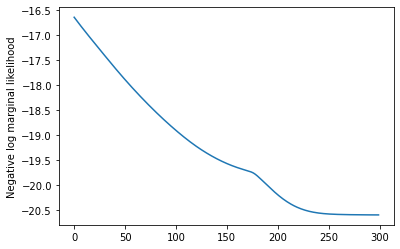

In [12]:
plt.plot(losses)
plt.ylabel("Negative log marginal likelihood");

We see that the method learned a good approximation to the true (generating) parameters, up to a permutation of the states (since the labels are unidentifiable). However, results can vary with different random seeds. We may find that the rates are the same for some states, which means those states are being treated as identical, and are therefore redundant.

## Plotting the posterior over states

In [13]:
hmm_posterior = hmm.filter(observed_counts)

In [14]:
posterior_probs = hmm_posterior.filtered_probs
rates = hmm.emission_rates.value

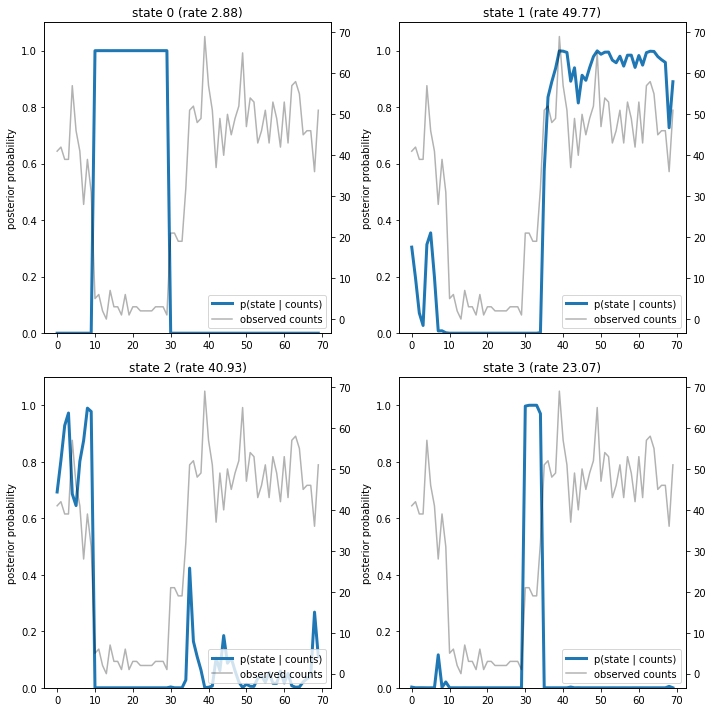

In [15]:
def plot_state_posterior(ax, state_posterior_probs, title):
    ln1 = ax.plot(state_posterior_probs, c="tab:blue", lw=3, label="p(state | counts)")
    ax.set_ylim(0.0, 1.1)
    ax.set_ylabel("posterior probability")
    ax2 = ax.twinx()
    ln2 = ax2.plot(observed_counts, c="black", alpha=0.3, label="observed counts")
    ax2.set_title(title)
    ax2.set_xlabel("time")
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color="white")
    ax2.grid(False)


fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1), posterior_probs[:, 0], title="state 0 (rate {:.2f})".format(rates[0,0]))
plot_state_posterior(fig.add_subplot(2, 2, 2), posterior_probs[:, 1], title="state 1 (rate {:.2f})".format(rates[1,0]))
plot_state_posterior(fig.add_subplot(2, 2, 3), posterior_probs[:, 2], title="state 2 (rate {:.2f})".format(rates[2,0]))
plot_state_posterior(fig.add_subplot(2, 2, 4), posterior_probs[:, 3], title="state 3 (rate {:.2f})".format(rates[3,0]))
plt.tight_layout()

In [16]:
# max marginals
most_probable_states = hmm.most_likely_states(observed_counts)
most_probable_rates = hmm.emission_rates.value[most_probable_states]

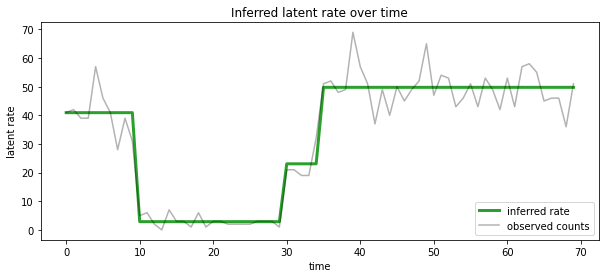

In [17]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c="tab:green", lw=3, label="inferred rate")
ax.plot(observed_counts, c="black", alpha=0.3, label="observed counts")
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4);

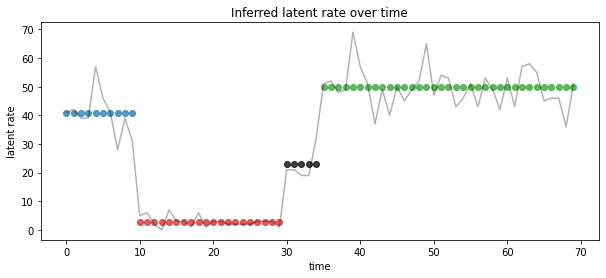

In [18]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
color_list = np.array(["tab:red", "tab:green", "tab:blue", "k"])
colors = color_list[most_probable_states]
for i in range(len(colors)):
    ax.plot(i, most_probable_rates[i], "-o", c=colors[i], lw=3, alpha=0.75)
ax.plot(observed_counts, c="black", alpha=0.3, label="observed counts")
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time");

## Model with unknown $K$

In general we don't know the true number of states. One way to select the 'best' model is to compute the one with the maximum marginal likelihood. Rather than summing over both discrete latent states and integrating over the unknown parameters $\lambda$, we just maximize over the parameters (empirical Bayes approximation).

$$p(x_{1:T}|K) \approx \max_\lambda \int p(x_{1:T}, z_{1:T} | \lambda, K) dz$$
We can do this by fitting a bank of separate HMMs in parallel, one for each value of $K$. We need to make them all the same size so we can batch them efficiently. To do this, we pad the transition matrices (and other paraemeter vectors) so they all have the same shape, and then use masking.

In [19]:
max_num_states = 6
states = jnp.arange(1, max_num_states + 1)

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_probs, batch_transition_probs = vmap(build_latent_state, in_axes=(0, None, None))(
    states, max_num_states, daily_change_prob
)

print("Shape of initial_state_probs: {}".format(batch_initial_state_probs.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state probs for num_states==3:\n{}".format(batch_initial_state_probs[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_probs: (6, 6)
Shape of transition probs: (6, 6, 6)
Example initial state probs for num_states==3:
[0.33333334 0.33333334 0.33333334 0.         0.         0.        ]
Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]


## Model fitting with gradient descent

In [20]:
rng_key, rng_normal = random.split(rng_key)

# Define variable to represent the unknown log rates.
trainable_log_rates = jnp.log(jnp.mean(observed_counts)) + random.normal(rng_normal, (max_num_states,1))

In [21]:
def _fit(initial_probabilities, transition_matrix, trainable_log_rates, emissions, optimizer, num_iters=50):

    hmm = PoissonHMM(initial_probabilities, transition_matrix, jnp.exp(trainable_log_rates))
    hmm.initial_probs.freeze()
    hmm.transition_matrix.freeze()

    rate_prior = distrax.LogStddevNormal(5, 5)
    hmm.emission_rates.prior = rate_prior

    x, losses = hmm_fit_sgd(hmm, emissions.reshape((1, -1)), optimizer=optimizer, num_iters=num_iters)

    return x.emission_rates.value, losses

In [22]:
num_iters = 400

vfit = vmap(_fit, in_axes=(0, 0, None, None, None, None))

rates, losses = vfit(
    batch_initial_state_probs, batch_transition_probs, trainable_log_rates, observed_counts, optimizer, num_iters
)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4488: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")


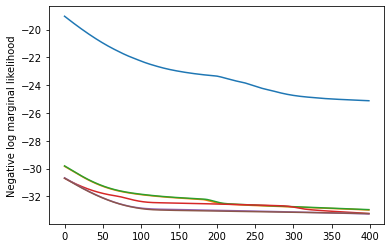

In [23]:
plt.plot(losses.T)
plt.ylabel("Negative log marginal likelihood");

## Plot marginal likelihood of each model

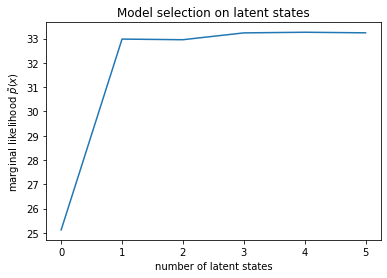

In [24]:
plt.plot(-losses[:, -1])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states");

## Plot posteriors

In [25]:
for i, rate in enumerate(rates):
    print("rates for {}-state model: {}".format(i + 1, rate[: i + 1]))

rates for 1-state model: [[33.187534]]
rates for 2-state model: [[45.12489 ]
 [ 2.899008]]
rates for 3-state model: [[ 45.12551  ]
 [  2.8990126]
 [186.56902  ]]
rates for 4-state model: [[ 48.8134  ]
 [  2.899032]
 [186.56902 ]
 [ 32.884853]]
rates for 5-state model: [[ 61.20109  ]
 [  2.8990328]
 [186.56902  ]
 [ 48.57019  ]
 [ 26.266996 ]]
rates for 6-state model: [[ 64.2271  ]
 [  2.899032]
 [186.56902 ]
 [ 40.84594 ]
 [ 22.339912]
 [ 49.720455]]


In [26]:
def posterior_marginals(initial_probabilities, transition_matrix, rate, emissions):

    hmm = PoissonHMM(initial_probabilities, transition_matrix, rate)

    # hmm_posterior = hmm.most_likely_states(emissions)
    return hmm.most_likely_states(emissions)


most_probable_states = vmap(posterior_marginals, in_axes=(0, 0, 0, None))(
    batch_initial_state_probs, batch_transition_probs, rates, observed_counts
)
# most_probable_states = jnp.argmax(posterior_probs, axis=-1)

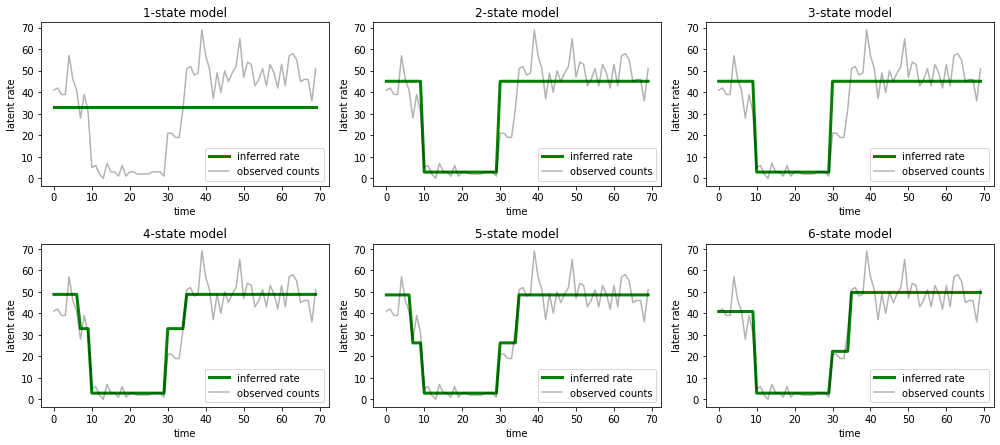

In [27]:
fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates in enumerate(rates):
    ax = fig.add_subplot(4, 3, i + 1)
    ax.plot(learned_model_rates[most_probable_states[i]], c="green", lw=3, label="inferred rate")
    ax.plot(observed_counts, c="black", alpha=0.3, label="observed counts")
    ax.set_ylabel("latent rate")
    ax.set_xlabel("time")
    ax.set_title("{}-state model".format(i + 1))
    ax.legend(loc=4)
plt.tight_layout()